# Text Mining Final Project 2019 - 2020

## Identifying Authors by Their Writings 

## Authors: 
- Inês Diogo (m20190301)
- Lara Neves (m20190867) 
- Susana Paço (m20190821)



**Objective:** To identify the authors of Portuguese texts by training a model with labeled texts from the same authors. 



**First Visual Analysis**
* Metadata was detected on the top of most txt's which can turn the bias up in the models. It was agreed that a good idea was to remove this crucial metadata from the corpora and test if it made a significant difference in the final result:
    + The name of the authors was detected in most of the metadata;
    + References to the authors' work was also detected.
* Texts from different eras of portuguese 


In [ ]:
#installs - please uncomment those packages that you don't have within your system in order to install them

import sys
#!{sys.executable} -m pip install -U unidecode
#!{sys.executable} -m pip install -U keras
#!{sys.executable} -m pip install -U tensorflow
#!{sys.executable} -m pip install -U nltk
#!{sys.executable} -m pip install git+https://github.com/textpipe/textpipe.git
#!{sys.executable} -m pip install -U spacy
#!{sys.executable} -m  spacy download pt_core_news_sm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from collections import defaultdict
from pathlib import Path
import pt_core_news_sm
import spacy
import os
import re

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import RSLPStemmer

from unidecode import unidecode
#nltk.download('rslp')
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
spacy_nlp = spacy.load('pt_core_news_sm')
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm #progressbar
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, Add,GlobalAveragePooling1D,Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

* [1. Data Pre-Processing](#DPP)
    
    * [1.1. Renaming txt Files](#rename)

    * [1.2. Extracting Data](#extract)
    
    * [1.3. Cleaning MetaData](#ClearMD)
    
    * [1.4 Preprocessing Data](#clearTexts)
    
    * [1.5  Dividing the texts into 500 word chunks](#chunks)

    
* [2. Brief Analysis](#BA)

    * [2.1  Choosing the Evaluation Metrics](#evalmet)
    
    * [2.2  Word Frequency](#wordcloud)
    
    * [2.3 Testing the Importance of Punctuation](#TIP)


* [3.  Creating a Baseline](#Baseline)

    * [3.1  Cross-validation](#crossvalidation)
    
    * [3.2  Bag-of-Words Baseline](#BOWB)
    
    * [3.3. Testing the Baseline with Different Levels of Preprocessing](#testingB)
    
* [4.  FastText Model](#fasttext)
    * [ 4.1 Predict Authors of Test Set](#predict)

    

<a class="anchor" id="DPP">

## 1. Data Preprocessing

</a>

<a class="anchor" id="rename">

### 1.1. Renaming .txt Files

</a>

We will start by renaming the .txt files so there's no duplicates and we create a standardized form to 
identify each .txt file.


In [2]:
def change_file_name(author):
    i = 0
    my_dir_path = "Data/Corpora/train/" + author
    
    for filename in os.listdir(my_dir_path): 
        
        #Define the new and old names with directory path
        new_name =str(author) + str(i) + ".txt"
        old_name = my_dir_path + '/' + filename 
        new_name = my_dir_path + '/' + new_name 
        
        #So it doesn't give out an error when it runs for the second time
        # rename all the files 
        if new_name != old_name: #IT STILL GIVES OUT ERROR
            os.rename(old_name, new_name) 
        i += 1

In [3]:
authors = ['AlmadaNegreiros','CamiloCasteloBranco','EcaDeQueiros','JoseRodriguesSantos','JoseSaramago','LuisaMarquesSilva']
authors_sigla = ['AN','CCB','EQ','JRS','JS','LMS']

#### WARNING: Only run the following code if the file names are the original otherwise, if it runs a second time, will give an error

In [4]:
#for a in range(len(authors)):
#    change_file_name(authors[a])

<a class="anchor" id="extract">

### 1.2. Extracting Data
</a>

We will now join together all the texts from the different authors' folders into one single dataframe called _traindf_ while replacing the authors names with their initials.

In [5]:
#Create a df for one author the respective .txt files in the corpora
def create_df_from_txt(author):
    my_dir_path = "Data/Corpora/train/" + author

    results = defaultdict(list)
    for file in Path(my_dir_path).iterdir():
        with open(file, "r",encoding = 'utf8') as file_open:
            results["id"].append(file.name)
            results["text"].append(file_open.read())
            results["author"] = author
            file_open.close()
    df = pd.DataFrame(results)
    
    return df

In [6]:
#Join together the dataframes from all the authors
def join_df(authors):

    df = pd.DataFrame()
    for a in range(len(authors)):
        df = df.append(create_df_from_txt(authors[a]))
    df.reset_index(inplace = True, drop = True)    
    return df 

In [7]:
### Running all the functions

#Creating the training data frame
traindf = join_df(authors)

#Replacing the name of the authors with labels of their initials
for i in range(0,len(authors)):
    traindf.author = traindf.author.replace(authors[i],authors_sigla[i])
traindf

,id,text,author
0,AlmadaNegreiros0.txt,Title: A Scena do Odio\n\nAuthor: José de Alma...,AN
1,AlmadaNegreiros1.txt,Title: O Jardim da Pierrette\n\nAuthor: José d...,AN
2,AlmadaNegreiros2.txt,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...,AN
3,AlmadaNegreiros3.txt,\nTitle: Litoral\n A Amadeo de Souza Car...,AN
4,AlmadaNegreiros4.txt,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...,AN
...,...,...,...
58,LuisaMarquesSilva4.txt,Título\ne-medo\n\nAutora (inspiradíssima)\nLuí...,LMS
59,LuisaMarquesSilva5.txt,"LISBOA 2050\nLisboa, ano de 2050. Um Agosto tã...",LMS
60,LuisaMarquesSilva6.txt,Título\nUm passeio pelo inferno\n\nAutora\nLuí...,LMS
61,LuisaMarquesSilva7.txt,Título\nRapsódia sem dó (maior)\n\nAutora\nLuí...,LMS


We will do the same with the test data set:

In [8]:
#Create a df for one author the respective .txt files in the corpora
def create_df_from_txttest(numberofwords):
    my_dir_path = "Data/Corpora/test/"+ str(numberofwords)

    results = defaultdict(list)
    for file in Path(my_dir_path).iterdir():
        with open(file, "r",encoding = 'utf8') as file_open:
            results["id"].append(file.name)
            results["text"].append(file_open.read())
            results["numberofwords"] = numberofwords
            file_open.close()
    df = pd.DataFrame(results)
    
    return df

In [9]:
def join_dftest(numberofwords):

    df = pd.DataFrame()
    for a in range(len(numberofwords)):
        df = df.append(create_df_from_txttest(numberofwords[a]))
    df.reset_index(inplace = True, drop = True)    
    return df 


In [10]:
numberofwords = [1000, 500]
testdf = join_dftest(numberofwords)
#checktable
testdf.head(3)

,id,text,numberofwords
0,text1.txt,"Depois, pouco a pouco, a tranquilidade regress...",1000
1,text2.txt,Justamente como se eu tivesse tido a ideia de ...,1000
2,text3.txt,"Quase um mês depois, a época de exames aproxim...",1000


<a class="anchor" id="clearMD">

### 1.3. Cleaning MetaData
</a>

The majority of the .txt files have metadata at the beginning. This is unnecessary and may introduce noise into our model, as such it may be a good idea to remove it. 

In [19]:
#author names to remove from metadata
authors = ["José de Almada Negreiros", "José de ALMADA-NEGREIROS", "JOSÉ DE ALMADA-NEGREIROS", "Almada Negreiros", "Camilo Castelo Branco", "CAMILLO CASTELLO BRANCO", "Eça de Queirós", "Eca de Queiros", "José Rodrigues dos Santos","Jose Rodrigues dos Santos", "JOSÉ RODRIGUES DOS SANTOS", "José Saramago", "Jose Saramago", "JoSÉ SaRamago", "Luísa Marques Silva", "Luisa Marques Silva", "Luísa Marques da Silva"]  

In [20]:
#book names to stop words
authorsandbooks = pd.read_excel('Data/AuthorsAndBooks.xlsx')
authorsandbooks.head(3)

,Eça de Queirós,Camilo Castelo Branco,Almada Negreiros,Saramago,José Rodrigues dos Santos,Luísa Marques Silva
0,O Mistério da Estrada de Sintra,Anátema,O Moinho,Terra do Pecado,"Comunicação, Difusão Cultural, 1992; Prefácio",Acabou-se!
1,O Crime do Padre Amaro,Os Mistérios de Lisboa,Os Outros,Manual de Pintura e Caligrafia,Crónicas de Guerra I - Da Crimeia a Dachau,Sete Histórias por Acontecer
2,A Tragédia da Rua das Flores,A Filha do Arcediago,"23, 2º Andar",Levantado do Chão,Crónicas de Guerra II - De Saigão a Bagdade,e-Medo


In [21]:
#authors work to arrays

# Eça Queirós books
Eca = authorsandbooks['Eça de Queirós']
Eca = Eca.dropna()
Eca = pd.array(Eca)


#Camilo Castelo Branco books
camilo = authorsandbooks['Camilo Castelo Branco']
camilo = camilo.dropna()
camilo = pd.array(camilo)


# Almada Negreiros books
Almada = authorsandbooks['Almada Negreiros']
Almada = Almada.dropna()
Almada = pd.array(Almada)


# Saramago books
Saramago = authorsandbooks['Saramago']
Saramago = Saramago.dropna()
Saramago = pd.array(Saramago)


# José Rodrigues dos Santos books
JRodriguesSantos = authorsandbooks['José Rodrigues dos Santos']
JRodriguesSantos = JRodriguesSantos.dropna()
JRodriguesSantos = pd.array(JRodriguesSantos)


# Luísa Marques Silva books
luisaMarquesSilva = authorsandbooks['Luísa Marques Silva']
luisaMarquesSilva = luisaMarquesSilva.dropna()
luisaMarquesSilva = pd.array(luisaMarquesSilva)

In [22]:
def removemetadata(doc):
    processed_corpus = []
    for i in tqdm(range(len(doc))):
        text = doc['text'].iloc[i,]
        for w in authors:
            text = re.sub(w,"",text)
        for x in Eca:
            text = re.sub(x,"",text)
        for t in camilo:
            text = re.sub(t,"",text)
        for s in Almada:
            text = re.sub(s,"",text)
        for y in Saramago:
            text = re.sub(y,"",text)
        for n in JRodriguesSantos:
            text = re.sub(n,"",text)
        for m in luisaMarquesSilva:
            text = re.sub(m,"",text)
        processed_corpus.append(text)
    return processed_corpus

In [23]:
#create a column to test the results of removing the metadata text
traindf['removeMetadata'] = removemetadata(traindf)
testdf['removeMetadata'] = removemetadata(testdf)

In [24]:
traindf.head()

,id,text,author,removeMetadata
0,AlmadaNegreiros0.txt,Title: A Scena do Odio\n\nAuthor: José de Alma...,AN,Title: \n\nAuthor: \n\nRelease Date: September...
1,AlmadaNegreiros1.txt,Title: O Jardim da Pierrette\n\nAuthor: José d...,AN,Title: \n\nAuthor: \n\nRelease Date: September...
2,AlmadaNegreiros2.txt,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...,AN,\n\nTitle: \n\nAuthor: \n\nRelease Date: Septe...
3,AlmadaNegreiros3.txt,\nTitle: Litoral\n A Amadeo de Souza Car...,AN,\nTitle: \n \n\nAuthor: \n\nContributor:...
4,AlmadaNegreiros4.txt,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...,AN,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...


<a class="anchor" id="clearTexts">

### 1.4. Preprocessing Data
    
</a>

In order to preprocess the data we created separate functions to achieve the following:
- lowercasing
- lemmatization
- removal of punctuation
- removal of stopwords
- removal of accents
It was important to separate them because we are looking to test the baseline model with differnt levels of preprocessing.

#### Auxiliary functions for preprocessing:

In [27]:
def lowercasing(text):       
    text = text.lower()     
    return text

def to_string(text):
    text = text.split()
    return text

def lemmatization(word):
    lem = WordNetLemmatizer()
    word =lem.lemmatize(word)
    return word

def punctuation(word):
    word = re.sub('[\“\”\ "\-\'`~!@#$%^&*()_|+=?;:,.<>\{\}\[\]\\\/]','', word)
    return word

def stopwords_nltk(word):
    stop_words = set(stopwords.words("portuguese")) 
    return word in stop_words

def stopwords_spacy(word):
    return spacy_nlp.vocab[word].is_stop

def accents(word):
    word = unidecode(word)
    return word

#### Preprocessing 1: with punctuation and no lemmatization

In [28]:
def preprocessing_with_punc(doc, column):
    processed_corpus = []
    for i in tqdm(range(len(doc))):
        text = doc[column].iloc[i,]    
    
        text = lowercasing(text)
        
        text = to_string(text)

        textfinal = []
        for word in text:
            if stopwords_nltk(punctuation(word)) or stopwords_spacy(punctuation(word)):
                word = re.sub('[^\“\”\ "\-\'`~!@#$%^&*()_|+=?;:,.<>\{\}\[\]\\\/]','', word)
            else:
                word
            textfinal.append(word)

        text = " ".join(textfinal)
    
        processed_corpus.append(text)
         
    return processed_corpus

In [29]:
#WARNING: this process will take some time
traindf['clean_with_punc'] = preprocessing_with_punc(traindf, 'removeMetadata')

#### Preprocessing 2: no punctuation and no lemmatization 

In [30]:
def preprocessing_no_punc(doc, column):
    processed_corpus = []
    for i in tqdm(range(len(doc))):
        text = doc[column].iloc[i,]    
    
        text = lowercasing(text)
        
        text = to_string(text)
        
        text = [punctuation(word) for word in text]

        text = [word for word in text if (not stopwords_nltk(word)) and (not stopwords_spacy(word))]
        
        text = [accents(word) for word in text] 

        text = " ".join(text)
    
        processed_corpus.append(text)
         
    return processed_corpus

In [31]:
traindf['clean_no_punc'] = preprocessing_no_punc(traindf, 'removeMetadata')

#### Preprocessing 3: no punctuation and with lemmatization

In [32]:
def preprocessing_clean(doc, column):
    processed_corpus = []
    for i in tqdm(range(len(doc))):
        text = doc[column].iloc[i,]    
    
        text = lowercasing(text)
        
        text = to_string(text)
        
        text = [punctuation(word) for word in text]

        text = [word for word in text if (not stopwords_nltk(word)) and (not stopwords_spacy(word))]
        
        text = [lemmatization(word) for word in text]
        
        text = [accents(word) for word in text] 

        text = " ".join(text)
    
        processed_corpus.append(text)
         
    return processed_corpus

In [33]:
traindf['clean'] = preprocessing_clean(traindf, 'removeMetadata')

<a class="anchor" id="chunks">

### 1.5 Dividing the texts into 500 word chunks
</a>

Given the different sized texts as well as the relatively low amount of data, we divided the texts into maximum of 500 word chunks while mantaining the author label. This way we have a much larger amount of data which will be particularly useful later on in the implementation of our models.

In [62]:
def split_doc(doc,column,n):
    newdf = pd.DataFrame()
    newdf = newdf.reindex(columns = ['id','chunks','author']) 
    for i in tqdm(range(len(doc))):
        text = doc[column].iloc[i,]

        text = text.split()

        chunks = [' '.join(text[j:j+n]) for j in range(0,len(text),n)]

        for c in chunks:
            data = []
            values = [doc['id'].iloc[i,], c, doc['author'].iloc[i,]]
            a_dictionary = dict(zip(newdf.columns.tolist(), values))
            data.append(a_dictionary)
            newdf = newdf.append(data)
            
    newdf.index =[j for j in range(len(newdf))]  
              
    return newdf

In [63]:
traindf_chunks = split_doc(traindf, 'clean' ,500)

In [64]:
traindf_chunks.head(10)

,id,chunks,author
0,AlmadaNegreiros0.txt,title author release date september 16 2007 eb...,AN
1,AlmadaNegreiros0.txt,sensibilidade manchada vinho lyrio bravo flore...,AN
2,AlmadaNegreiros0.txt,negro pendao piratas heide corvo marinho beber...,AN
3,AlmadaNegreiros1.txt,title author release date september 23 2007 eb...,AN
4,AlmadaNegreiros2.txt,title author release date september 29 2007 eb...,AN
5,AlmadaNegreiros2.txt,explicam senhora homem senhoras menina loira h...,AN
6,AlmadaNegreiros2.txt,cances sorte <<nao tenhas medo estares cabeca ...,AN
7,AlmadaNegreiros2.txt,atrapalhado pensei responder verdade disse ver...,AN
8,AlmadaNegreiros2.txt,espera penso verdade for matome gosto bois bar...,AN
9,AlmadaNegreiros2.txt,sahi casa mae irmao extrangeiro infelicidade m...,AN


<a class="anchor" id="BA">

## 2. Brief Analysis 

</a>

<a class="anchor" id="evalmet">

### 2.1 Choosing the Evaluation Metrics
</a>

Can we use Accuracy as an evaluation metric? Depends if the dataset is unbalanced. Let's check:

In [34]:
traindf.iloc[:,2].value_counts()

CCB    20
JS     12
LMS     9
AN      9
JRS     8
EQ      5
Name: author, dtype: int64

It is unbalanced in favour of Camilo Castelo Branco which is why we get a higher accuracy when we use the DummyClassifier below with most frequent strategy compared to other strategies (stratified) even though it's just classifying all texts as belonging to CCB. 

As such accuracy may not be the best metric in this case and we will also use the F1 Score as it integrates Precision and Recall simultaneously.

In [38]:
def dummy_classifier_score(df,text_column,strategy):

    X = df.loc[:,text_column]
    y = df.loc[:,'author']
    dummy_clf = DummyClassifier(strategy=strategy) #stratified, most_frequent
    dummy_clf.fit(X, y)
    dummy_clf.predict(X)
    return dummy_clf.score(X, y)

In [39]:
dummy_classifier_score(traindf,'text','most_frequent')

0.31746031746031744

In [40]:
dummy_classifier_score(traindf,'text','stratified')

0.15873015873015872

<a class="anchor" id="wordcloud">
    
### 2.2 Word Frequency
</a>

It can be interesting to check which words are the most frequent, particularly in order to make sure that all the document-specific stop words have been removed. 

To do so we created a word cloud for each author. To see each just type in the function one of the following siglas: 

In [41]:
authors_sigla

['AN', 'CCB', 'EQ', 'JRS', 'JS', 'LMS']

Corresponding to the following authors:

In [47]:
authors

['José de Almada Negreiros',
 'José de ALMADA-NEGREIROS',
 'JOSÉ DE ALMADA-NEGREIROS',
 'Almada Negreiros',
 'Camilo Castelo Branco',
 'CAMILLO CASTELLO BRANCO',
 'Eça de Queirós',
 'Eca de Queiros',
 'José Rodrigues dos Santos',
 'Jose Rodrigues dos Santos',
 'JOSÉ RODRIGUES DOS SANTOS',
 'José Saramago',
 'Jose Saramago',
 'JoSÉ SaRamago',
 'Luísa Marques Silva',
 'Luisa Marques Silva',
 'Luísa Marques da Silva']

In [48]:
def word_cloud(author,text_column):
    word_cloud = " ".join(traindf[traindf['author']==author][text_column])


    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(word_cloud)
    # Display the generated image:
    plt.figure(figsize=(17,7))
    plt.title('Word Cloud from ' + author)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

We know that we have contemporary authors and authors with an older style of Portuguese, can we see evidence of this in the word clouds? Let's check for José Rodrigues Santos and Camilo Castelo Branco:

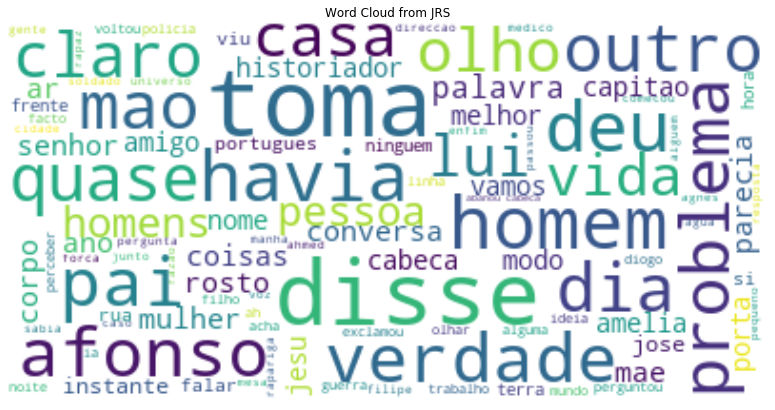

In [49]:
#Recent author
word_cloud('JRS','clean')

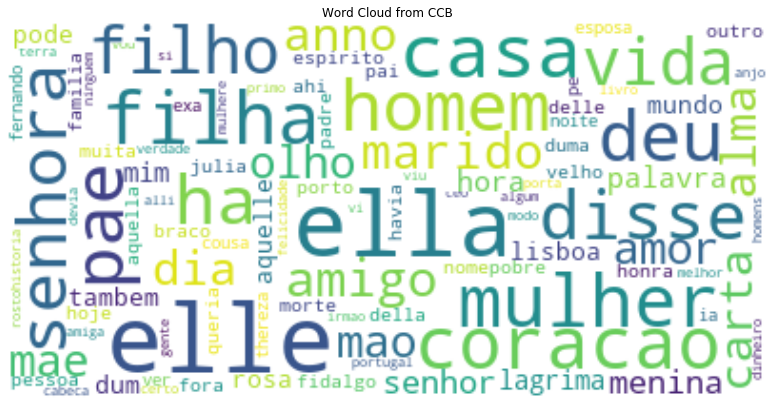

In [50]:
#Older author
word_cloud('CCB','clean')

What about the distribution of the N-grams on the entire corpus:

In [59]:
def get_top_n_grams(corpus, top_k, n):
    """
    Function that receives a list of documents (corpus) and extracts
        the top k most frequent n-grams for that corpus.
        
    :param corpus: list of texts
    :param top_k: int with the number of n-grams that we want to extract
    :param n: n gram type to be considered 
             (if n=1 extracts unigrams, if n=2 extracts bigrams, ...)
             
    :return: Returns a sorted dataframe in which the first column 
        contains the extracted ngrams and the second column contains
        the respective counts
    """
    vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
        
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]
    return top_df

In [60]:
top_df = get_top_n_grams(traindf['clean'], top_k=20, n=1)
top_df

,Ngram,Freq
0,disse,6011
1,dia,5495
2,olhos,4874
3,homem,4652
4,casa,4563
5,senhor,4120
6,mulher,3988
7,elle,3721
8,vida,3650
9,outro,3603


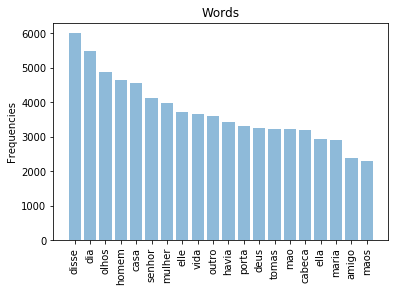

In [61]:
def plot_frequencies(top_df):
    """
    Function that receives a dataframe from the "get_top_n_grams" function
    and plots the frequencies in a bar plot.
    """
    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()
plot_frequencies(top_df)

<a class="anchor" id="TIP">

### 2.3. Testing the Importance of Punctuation

</a>
We know that José Saramago has an interesting use of punctuation and it can be a factor in identifying texts from him. Does this mean that we shouldn't consider punctuations as stop-words? Let's test it.

To do so we will use a dummy classifier on two texts from Saramago and two from JRS. Will we see a difference in the performance of the classifier with or without punctuation?

In [65]:
punc_traindf = traindf[traindf.author=='JS'][1:3].append(traindf[traindf.author=='JRS'][1:3])

We will run the dummy classifier n_iter times and determine the difference between the two. If the classifier is better with punctuation we should see a _positive difference_ meaning that the classifier that runs on the text with punctuation should have a better accuracy score than the one without. 

In [66]:
n_iter = 50000
score_punc_test = []
for i in range(0,n_iter):
    score_punc_test.append(dummy_classifier_score(punc_traindf,'clean_with_punc','stratified')-dummy_classifier_score(punc_traindf,'clean','stratified'))
    i += 1
score_punc_test = pd.DataFrame(score_punc_test)

In [67]:
score_punc_test.describe()

,0
count,50000.000000
mean,-0.002125
std,0.353803
min,-1.000000
25%,-0.250000
50%,0.000000
75%,0.250000
max,1.000000


There's a very very small change between each classifiers. Which may indicate that there are no difference in the performance of the classifier of JS with or without punctuation. 

To confirm this, let's do a one sided hypothesis test, where the null hypothesis is that the mean of the difference between the scores is zero, meaning there is no difference between doing a classifier with or without punctuation for José Saramago.

In [68]:
from scipy.stats import ttest_1samp

diff_mean = np.mean(score_punc_test)
print('mean', diff_mean)
tset, pval = ttest_1samp(score_punc_test, 0)
print('p-values', pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print("Reject the null hypothesis: there are evidence that the classifier performs differently if there's punctuation")
else:
  print("Do not reject the null hypothesis: there are no evidence that the classifier is better if we mantain the punctuation")

mean 0   -0.002125
dtype: float64
p-values [0.17927195]
Do not reject the null hypothesis: there are no evidence that the classifier is better if we mantain the punctuation


<a class="anchor" id="Baseline">

## 3. Creating a Baseline
    
</a>

Our goal now is to create a naíve baseline to compare our main models with, as well as to test the different levels of preprocessing of the data.

<a class="anchor" id="crossvalidation">

### 3.1. Cross-validation

</a>
We already have a test set defined however there is value in having an validation/development set to determine the model performance as it's being trained and to adjust the parameters.

Given the relatively small amount of data (if we don't consider the chunks) we chose to use cross-validation rather than splitting the set into training and evaluation sets for now.

We will do so by applying the k-fold crossvalidation method, the choice of number of folds k will be decided according to:

"... there is a bias-variance trade-off associated with the choice of k in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance." - Page 184, An Introduction to Statistical Learning, 2013.

In [69]:
#Creating a k-fold instance where the number of splits is 10
kf = KFold(n_splits=10)

In [70]:
#Defining accuracy score function
def evaluate_model(X,y, model):
    return model.score(X,y)

#### Dummy Classifier Baseline
Using a Dummy Classifier inside a crossvalidation k-fold 

In [71]:
#Placeholder dummy classifier
def dummy_classifier_model(X,y,strategy):
    dummy_clf = DummyClassifier(strategy=strategy) #stratified, most_frequent
    model = dummy_clf.fit(X, y)
    return model

In [72]:
#For the dummy classifier
def avg_score_DC(method,X,y,strategy, metric):
    score_train = []
    score_eval = []
    for train_index, eval_index in method.split(X):
        X_train, X_eval = X.iloc[train_index], X.iloc[eval_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[eval_index]
        ####Define model:
        model = dummy_classifier_model(X_train,y_train,strategy)
        ###############
        if metric == 'accuracy':
            value_train = evaluate_model(X_train, y_train, model)
            value_eval = evaluate_model(X_eval,y_eval, model)
            
        elif metric == 'f1 score':
            yhat_train = model.predict(X_train)
            yhat_eval = model.predict(X_eval)
            value_train = f1_score(y_train, yhat_train, average='weighted')
            value_eval = f1_score(y_eval, yhat_eval, average='weighted')
        score_train.append(value_train)
        score_eval.append(value_eval)
        
    print('Evaluation measure used:', metric)
    print('Train:', np.mean(score_train))
    print('Evaluation:', np.mean(score_eval))

In [73]:
avg_score_DC(kf,traindf['clean'],traindf['author'],'stratified','accuracy')

Evaluation measure used: accuracy
Train: 0.18712406015037591
Evaluation: 0.17142857142857143


In [74]:
avg_score_DC(kf,traindf['clean'],traindf['author'],'stratified','f1 score')

Evaluation measure used: f1 score
Train: 0.19690853767138386
Evaluation: 0.14182539682539683


Very bad result with dummy classifier as expected. Creating a bag-of-words for the baseline is probably a better choice: 

<a class="anchor" id="BOWB">

### 3.2. Bag-of-Words Baseline

</a>

In [75]:
def bag_of_words_model(X,y):
    count_vect = CountVectorizer(
        max_df=0.8,
        max_features=10000, 
        ngram_range=(1,3)
    )
    
    X_count = count_vect.fit_transform(X)
    #using frequencies instead of occurrences in order to normalize the counts for 
    #documents that are larger compared to smaller ones -term frequency
    #As well as downscaling weights for words that occur in many documntenst in the corpus
    #and are therefore less informative 

    X_train_tfidf =  TfidfTransformer().fit_transform(X_count)
    #Now that we have the features we can train the classifier. 
    #Let's use a naive bayes classsifier in the multinomial variant as it's the most well suited for word counts
    model = MultinomialNB().fit(X_train_tfidf, y)
    return model, X_train_tfidf

In [76]:
def avg_score_baseline(method,X,y, metric):
    #Using Bag-of-Words
    score_train = []
    score_eval = []
    for train_index, eval_index in method.split(X):
        X_train, X_eval = X.iloc[train_index], X.iloc[eval_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[eval_index]
        
        ##Define model:
        model = bag_of_words_model(X_train,y_train)[0]
        
        ##Evaluation of baseline model
        #The evaluate_model functions needs to use the respective X_train with the tfid transformer.
        if metric == 'accuracy':
            value_train = evaluate_model(bag_of_words_model(X_train,y_train)[1], y_train, model)
            value_eval = evaluate_model(bag_of_words_model(X_eval,y_eval)[1],y_eval, model)
            
        elif metric == 'f1 score':
            yhat_train = model.predict(bag_of_words_model(X_train,y_train)[1])
            yhat_eval = model.predict(bag_of_words_model(X_eval,y_eval)[1])
            value_train = f1_score(y_train, yhat_train, average='weighted')
            value_eval = f1_score(y_eval, yhat_eval, average='weighted')

        score_train.append(value_train)
        score_eval.append(value_eval)
        
    return [np.mean(score_train),np.mean(score_eval)]

#### Dataframe to save the scores

We need a dataframe that will save the scores of the baseline from the different levels of preprocessing 

In [77]:
df_scores= pd.DataFrame()
df_scores = df_scores.reindex(columns = ['testing','metric','training set', 'evaluation set']) 

In [78]:
def doc_score_baseline(df, doc,column, metric):
    data = []
    score_train = avg_score_baseline(kf,doc[column],doc['author'], metric)[0]
    score_eval = avg_score_baseline(kf,doc[column],doc['author'], metric)[1]
    values = [column, metric, score_train, score_eval]
    a_dictionary = dict(zip(df.columns.tolist(), values))
    data.append(a_dictionary)
    df = df.append(data)
            
    df.index =[j for j in range(len(df))]  
    print('Evaluation measure used:', metric)
    print('Train:', score_train)
    print('Evaluation:', score_eval)              
    return df


<a class="anchor" id="testingB">

### 3.3. Testing the Baseline with Different Levels of Preprocessing

</a>

In [79]:
df_scores = doc_score_baseline(df_scores, traindf, 'text', 'accuracy')

Evaluation measure used: accuracy
Train: 0.806296992481203
Evaluation: 0.2619047619047619


In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'text', 'f1 score')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'removeMetadata', 'accuracy')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'removeMetadata', 'f1 score')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean_with_punc', 'accuracy')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean_with_punc', 'f1 score')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean_no_punc', 'accuracy')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean_no_punc', 'f1 score')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean', 'accuracy')

In [ ]:
df_scores = doc_score_baseline(df_scores, traindf, 'clean', 'f1 score')

In [ ]:
df_scores

<a class="anchor" id="plotB">

### 3.4. Plotting the Baseline Results
</a>

In [ ]:
def plot_metric(axP, metric):
    axP.plot(df_scores['testing'].loc[df_scores['metric']== metric], df_scores['training set'].loc[df_scores['metric']== metric], 'g', label = 'Training set')
    axP.plot(df_scores['testing'].loc[df_scores['metric']== metric], df_scores['evaluation set'].loc[df_scores['metric']== metric], 'b', label = 'Evaluation set')
    axP.set_title(metric)
    axP.set_ylabel('Score')
    axP.legend()

In [ ]:
fig = plt.figure(figsize=(15,10))

grid=plt.GridSpec(6,6, wspace=0.7)
ax1 = fig.add_subplot(grid[0:3,0:3])
ax2 = fig.add_subplot(grid[0:3,3:6])

plot_metric(ax1, 'accuracy')
plot_metric(ax2, 'f1 score')

<a class="anchor" id="fasttext">

## 4. FastText Model
</a>

FastText is very fast and strong algorithm, developed by Facebook for text classification based on Continuous Bag-of-Words model a.k.a Word2vec.

#### Parameters:

In [ ]:
#Parameters:
maxlen = 500
min_count = 3
epochs = 100 #25

#### Define which dataset and which column - which level of pre-processing - to be used:

Note that the best results will come from using chunks with data preprocessed according to section 1.

In [ ]:
df_fasttext = traindf_chunks #traindf
column_fasttext = 'chunks' #'clean'

#### Calculate F1 Score:
As it was discussed in section 2.1, besides _accuracy_ we will also use the _F1 score_ to evaluate the model:

In [ ]:
#Evaluation metrics

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#### Run the algorithm:


In [ ]:
def create_docs(df,column, n_gram_max=3):
    def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                        ngrams.append('--'.join(q[w_index:w_index+n]))
                return q + ngrams
    def add_n_skip_gram(q, n_gram_max):
            ngrams = []
            for n in range(3, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    temp_list = [q[w_index],q[w_index+2]]
                    ngrams.append('--'.join(temp_list))
            return q + ngrams
        
    docs = []
    for doc in df[column]:
        doc = doc.split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
    return docs

docs = create_docs(df_fasttext,column_fasttext) ##

tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(docs)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs)

word_index = tokenizer.word_index
docs = tokenizer.texts_to_sequences(docs)
docs = pad_sequences(sequences=docs, maxlen=maxlen, truncating = 'post')
input_dim = np.max(docs) + 1

def create_model(embedding_dims=20, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(6, activation='softmax')) #Number of authors, or labels to be classified is 6
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy',f1_m,precision_m, recall_m])
    return model
model_ft = create_model()

a2c = {'AN': 0, 'CCB' : 1, 'EQ' : 2,'JRS': 3,'JS': 4,'LMS': 5}

y = np.array([a2c[a] for a in df_fasttext.author])
y = to_categorical(y)

STAMP1 = 'fast_text' 
bst_model_path1 = STAMP1 + '.h5'
model_checkpoint1 = ModelCheckpoint(bst_model_path1, save_best_only=True, save_weights_only=True)


#### Split the training set into train and validation sets:

We will not use crossvalidation in this case


In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_val, y_train, y_val = train_test_split(docs,y, test_size=0.2)


#### Fit the model and results:

In [ ]:
hist = model_ft.fit(x_train, y_train,
                 batch_size=256,
                 validation_data=(x_val, y_val),
                 epochs=epochs,
                 callbacks=[EarlyStopping(patience=0, monitor='val_loss'), model_checkpoint1])

In [ ]:
def get_layer_outputs():
    test_image = x_train
    outputs    = [layer.output for layer in model_ft.layers]          # all layer outputs


    comp_graph = [K.function([model_ft.input] + [K.learning_phase()], [output]) for output in outputs]  # evaluation functions
    # Testing
    layer_outputs_list = [op([test_image, 1]) for op in comp_graph]

    layer_outputs = []
    for layer_output in layer_outputs_list:
        #print(layer_output[0][0].shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])
    return layer_outputs_list

#get_layer_outputs()[2][0].shape
np.random.seed(7)
softmax_val = get_layer_outputs()[2][0].tolist()
softmax_label = pd.DataFrame(softmax_val, columns = ['AN','CCB','EQ','JRS','JS','LMS'])
a2c = {0: 'AN', 1 : 'CCB', 2 : 'EQ', 3 : 'JRS', 4 : 'JS', 5 : 'LMS'}

#Displays the ground truth for each chunk
y_str = []
for value in y_train:
    if value[0] == 1:
        y_str.append('AN')
    if value[1] == 1:
        y_str.append('CCB')
    if value[2] == 1:
        y_str.append('EQ')
    if value[3] == 1:
        y_str.append('JRS')
    if value[4] == 1:
        y_str.append('JS')
    if value[5] == 1:
        y_str.append('LMS')

author_label = pd.DataFrame(y_str, columns = ['author'])
result = pd.concat([softmax_label, author_label],axis=1)
result

In [ ]:
loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model_ft.evaluate(x_train, y_train, verbose=0)
print('Training Set: Accuracy = ', accuracy_train, 'F1 Score = ', f1_score_train)

In [ ]:
loss_val, accuracy_val, f1_score_val, precision_val, recall_val = model_ft.evaluate(x_val, y_val, verbose=0)
print('Validation Set: Accuracy = ', accuracy_val, 'F1 Score = ', f1_score_val)

<a class="anchor" id="predict">

### 4.1 Predict Authors of Test Set
</a>

Now we are finally ready to predict the authors of the texts present in the Test set. First we need to prepare the data in a similar way as we did previously for the Training set.

In [ ]:
#Create a df for one author the respective .txt files in the corpora
def create_df_from_txttest(numberofwords):
    my_dir_path = "Data/Corpora/test/"+ str(numberofwords)

    results = defaultdict(list)
    for file in Path(my_dir_path).iterdir():
        with open(file, "r",encoding = 'utf8') as file_open:
            results["id"].append(file.name)
            results["text"].append(file_open.read())
            results["numberofwords"] = numberofwords
            file_open.close()
    df = pd.DataFrame(results)
    
    return df

In [ ]:
def join_dftest(numberofwords):

    df = pd.DataFrame()
    for a in range(len(numberofwords)):
        df = df.append(create_df_from_txttest(numberofwords[a]))
    df.reset_index(inplace = True, drop = True)    
    return df 

In [ ]:
numberofwords = [1000, 500]
### Running all the functions

#Creating the training data frame and cleaning it
testdf = join_dftest(numberofwords)
testdf['clean'] = preprocessing_clean(testdf, 'text')
testdf

#### Tokenize the test set

In [ ]:
docs_test = create_docs(testdf,'clean') ##
tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(docs_test)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(docs_test)
word_index = tokenizer.word_index
docs_test = tokenizer.texts_to_sequences(docs_test)
docs_test = pad_sequences(sequences=docs_test, maxlen=maxlen, truncating = 'post')

#### Results

In [ ]:
results_test = model_ft.predict(docs_test)

# fill a y_test column with possible answers

testdf.loc[testdf['id'] == 'text1.txt', 'possibleanswer'] = 'JS'
testdf.loc[testdf['id'] == 'text2.txt', 'possibleanswer'] = 'AN'
testdf.loc[testdf['id'] == 'text3.txt', 'possibleanswer'] = 'unknown'
testdf.loc[testdf['id'] == 'text4.txt', 'possibleanswer'] = 'EQ'
testdf.loc[testdf['id'] == 'text5.txt', 'possibleanswer'] = 'CCB'
testdf.loc[testdf['id'] == 'text6.txt', 'possibleanswer'] = 'JRS'

results_test = pd.DataFrame(results_test, columns=['AN','CCB','EQ','JRS','JS','LMS'])
results_test['prediction'] = results_test[['AN','CCB','EQ','JRS','JS','LMS']].idxmax(axis=1)
results_test ['possibleresult'] = y_test
results_test.insert(0, "id", id)
results_test